In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import figure_utils as utils
import truncated_normal as tn

from scipy.stats import ttest_ind, ranksums

%matplotlib inline

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Load data
data_dir = './'
data_R = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_preprocessed.txt'), delimiter=' ')
labels_R = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_labels.txt'), delimiter=' ')
tsne_R = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_tsne.txt'), delimiter=' ')
data = np.array(data_R).T
labels = np.array(labels_R).reshape(-1)
tsne = np.array(tsne_R)
genes = np.array(data_R.index)

In [3]:
cellsamp1 = pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_0v1_cellsamp1.txt'), delimiter=' ')
pdict = {j:i for i, j in enumerate(data_R.columns)}
cellsamp_inds = np.array([pdict[i] for i in np.array(cellsamp1).reshape(-1)])
cellsamp1labels = np.array(pd.read_csv(os.path.join(data_dir, 'pbmc_seurat_0v1_cellsamplabels1.txt'), delimiter=' ')).reshape(-1)

# get hyperplane using first half of dataset
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=100)
svm.fit(data[cellsamp_inds], cellsamp1labels)
a = svm.coef_.reshape(-1)
labels1hat = svm.predict(data[cellsamp_inds])
print('Consistency of new labels with old: %.3f'\
      %(np.sum(labels1hat == cellsamp1labels)/float(len(cellsamp1labels))))

# assign points in second half of dataset
inds = np.ones(len(data)).astype(bool)
inds[cellsamp_inds] = 0
for i in np.unique(labels):
    if i != 0 and i != 1:
        inds[labels == i] = 0
labels2 = svm.predict(data[inds])
y, z = data[inds][labels2 == 0], data[inds][labels2 == 1]

np.savetxt('pbmc_seurat_0v1_cellsamp2.txt', data_R.columns[inds], fmt='%s')
np.savetxt('pbmc_seurat_0v1_cellsamplabels2.txt', labels2, fmt='%s')
np.savetxt('pbmc_filtered_genes.txt', keep_inds)

Consistency of new labels with old: 1.000


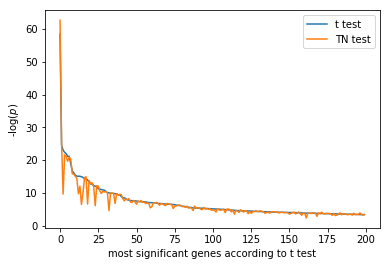

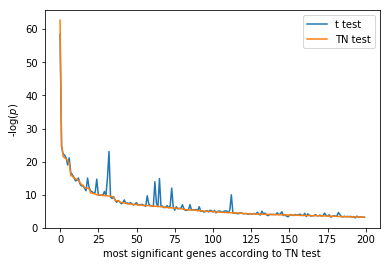

In [4]:
keep_inds = np.var(np.vstack((y, z)), 0) > 0
y = y[:, keep_inds]
z = z[:, keep_inds]
a = a[keep_inds]

picklefile = 'pickled/pbmc_0v1.pickle'
if os.path.isfile(picklefile):
    p_t, p_tn = pickle.load(open(picklefile, 'rb'))
else:
    p_t = ttest_ind(y, z)[1]
    p_tn = tn.tn_test(y, z, a=a, verbose=True, learning_rate=0.5, eps=1e-1)
    pickle.dump((p_t, p_tn), open(picklefile, 'wb'))

plt.plot(-np.log10(np.sort(p_t)[:200]), label='t test')
plt.plot(-np.log10(p_tn[np.argsort(p_t)[:200]]), label='TN test')
plt.xlabel('most significant genes according to t test')
plt.ylabel('-log($p$)')
plt.legend()
plt.show()

plt.plot(-np.log10(p_t[np.argsort(p_tn)[:200]]), label='t test')
plt.plot(-np.log10(np.sort(p_tn)[:200]), label='TN test')
plt.xlabel('most significant genes according to TN test')
plt.ylabel('-log($p$)')
plt.legend()
plt.show()